In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

import pandas_datareader.data as web

from keras.callbacks import EarlyStopping

import keras
from keras.models import load_model

#from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

import warnings
warnings.filterwarnings('ignore')

Using Theano backend.


In [2]:
def stockplotter(ticker, plot=True):
    
    try:
        #stock = pdr.get_data_yahoo(ticker,start,end)
        data = {}
        for stock in ticker:
            data = web.DataReader(stock,'yahoo','2018','2021')['Adj Close']
        df_1 = pd.DataFrame(data)#.reset_index()
        if plot==True:
            df_1.plot(figsize=(12,8))
            plt.title("Housing Price Trends ")
            #plt.set(title=f'Housing Prices by Year - {zip_df.index.freq}')
            plt.xlabel('Year')
            plt.ylabel('Home Prices')
            plt.legend(bbox_to_anchor=(1.05,1),loc='upper left') 
        
        return df_1
     
    except Exception as e:
        print("Error occured:", e)
        #data = 'Incorrect Symbol'


Symbols,AAPL,GOOGL,AMZN,MSFT,DAL
Date,,,,,
2018-01-02,41.442081,1073.209961,1189.010010,82.383636,53.520050
2018-01-03,41.434864,1091.520020,1204.199951,82.767044,52.529640
2018-01-04,41.627323,1095.760010,1209.589966,83.495522,52.529640
2018-01-05,42.101261,1110.290039,1229.140015,84.530701,52.793751
2018-01-08,41.944889,1114.209961,1246.869995,84.616966,51.576958
...,...,...,...,...,...
2020-12-24,131.970001,1734.160034,3172.689941,222.750000,39.730000
2020-12-28,136.690002,1773.959961,3283.959961,224.960007,40.150002
2020-12-29,134.869995,1757.760010,3322.000000,224.149994,40.029999


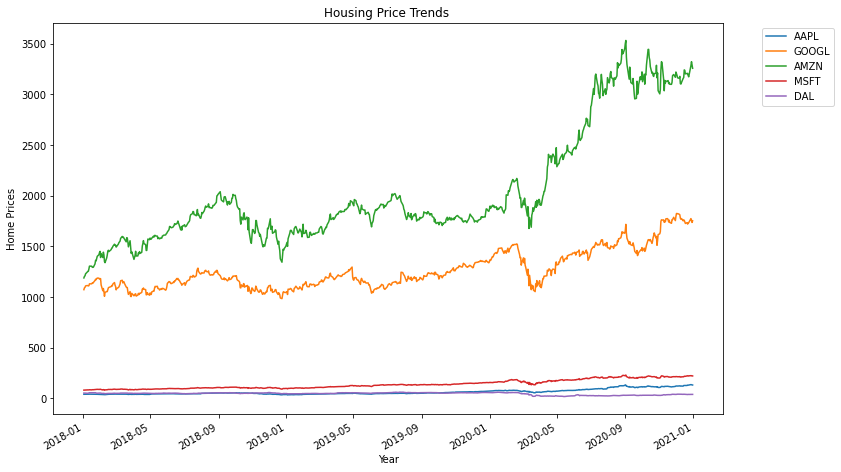

In [3]:
#df_1 = stockplotter(['XYZC'])
df_1 = stockplotter([['AAPL','GOOGL','AMZN','MSFT','DAL']], plot=True)
df_1

## **Forecasting**

In [4]:
def get_data(symbol, data_source,start,end):
    df = web.DataReader(symbol,data_source, start, end) 
    print(df.shape)
    
    plt.figure(figsize=(12,8))
    plt.plot(df['Close'])
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    return df

(1265, 6)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-04,73.709999,71.529999,71.839996,73.550003,8233300.0,62.800835
2016-01-05,75.239998,73.629997,73.739998,74.839996,8191400.0,63.902309
2016-01-06,74.800003,73.379997,73.800003,74.080002,4921400.0,63.253376
2016-01-07,76.000000,73.489998,73.580002,73.879997,11289900.0,63.082607
2016-01-08,74.790001,71.269997,74.209999,71.379997,7749000.0,60.947964
...,...,...,...,...,...,...
2021-01-05,181.970001,176.429993,176.800003,180.369995,4843300.0,180.369995
2021-01-06,189.470001,180.110001,180.330002,188.919998,5610100.0,188.919998
2021-01-07,192.350006,189.169998,189.210007,191.100006,4226700.0,191.100006


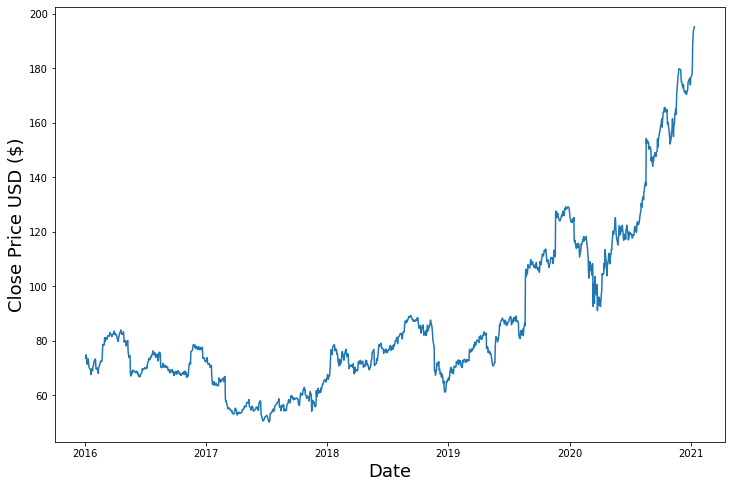

In [5]:
the_data = get_data('TGT',data_source='yahoo', start='2016-01-01',end='2021-1-11')
the_data

In [6]:
#df = pd.read_csv('data/apple_2012_1_1-2019_12_17.csv', parse_dates=True, index_col=[0])

#Get the stock quote 
#df = web.DataReader('TGT', data_source='yahoo', start='2016-01-01', end='2021-1-11') 

In [7]:
#df = df.diff().dropna() #zip_df[11226].diff().dropna()

In [8]:
#dataset = df['Close']
# dataset = data.values

In [9]:
def preprocessing(df,percentage):
    training_data_len = int(np.round(len(df) * percentage))
    dataset = pd.DataFrame(df)
    scaler = MinMaxScaler(feature_range = (0, 1))
    scaled_data = scaler.fit_transform(dataset)
    return training_data_len, dataset, scaler, scaled_data

In [10]:
#training_data_len, dataset, scaler, scaled_data = preprocessing(df['Close'], percentage=.8)
training_data_len, dataset, scaler, scaled_data = preprocessing(the_data['Adj Close'], percentage=.8)

In [11]:
def create_sets(training_data_len):
    #create training data set
    train_data = scaled_data[0:training_data_len,:]
    test_data = scaled_data[training_data_len -60:,:] #to 2003 which is end of dataset
    #split data into X_train and y_train data sets
    X_train = []
    y_train = []
    #create dataset X_test and y_test data sets
    X_test = []
    y_test = []    #dataset.iloc[training_data_len:, :]


    for i in range(60, len(train_data)):
        X_train.append(train_data[i-60:i])
        y_train.append(train_data[i,0]) #will contain 61st value which will be at position 60

    for i in range(60, len(test_data)):
        X_test.append(test_data[i-60:i,0]) 
        y_test.append(test_data[i,0])
        
    X_train, y_train = np.array(X_train), np.array(y_train)  
    X_test = np.array(X_test) #added
    X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1)) #added
    y_test = np.array(y_test)
        
    return X_train, X_test, y_train, y_test    

In [12]:
X_train, X_test, y_train, y_test = create_sets(training_data_len)

In [13]:
#early_stop = EarlyStopping(monitor='val_loss', patience=2)

def create_model(X_train, y_train):
    model = Sequential()

    model.add(LSTM(units = 50, return_sequences = True, input_shape=(X_train.shape[1],1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = False))
    model.add(Dropout(0.2))

    model.add(Dense(units = 25))
    model.add(Dense(units = 1))

    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    model.summary()
    
    return model


In [14]:

model = create_model(X_train,y_train)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)               

In [15]:
#callbacks=[early_stop]
early_stop = EarlyStopping(monitor='val_loss', patience=2)
model.fit(X_train,y_train, epochs=50,batch_size=32,callbacks=[early_stop])     

Epoch 1/50
952/952 [==============================] - 4s 4ms/step - loss: 0.0069
Epoch 2/50
952/952 [==============================] - 3s 4ms/step - loss: 0.0012
Epoch 3/50
952/952 [==============================] - 4s 4ms/step - loss: 0.0013
Epoch 4/50
952/952 [==============================] - 4s 4ms/step - loss: 0.0011
Epoch 5/50
952/952 [==============================] - 4s 4ms/step - loss: 0.0010
Epoch 6/50
952/952 [==============================] - 3s 4ms/step - loss: 9.3147e-04
Epoch 7/50
952/952 [==============================] - 4s 4ms/step - loss: 8.0413e-04
Epoch 8/50
952/952 [==============================] - 3s 4ms/step - loss: 8.9370e-04
Epoch 9/50
952/952 [==============================] - 3s 4ms/step - loss: 7.2296e-04
Epoch 10/50
952/952 [==============================] - 4s 4ms/step - loss: 7.3067e-04
Epoch 11/50
952/952 [==============================] - 4s 5ms/step - loss: 6.5597e-04
Epoch 12/50
952/952 [==============================] - 3s 4ms/step - loss: 7.3788e-

In [20]:
#model.summary()

In [21]:
# #train the model
# #model checkpoint save_weights_only=True
# #fresh_model.load_weights  load_model
# #model.save(), load_model('')
# model.fit(X_train,y_train, epochs=50, batch_size=32 ) 

In [22]:
def save_model():
    model.save('model_parameters')
    model_params = keras.models.load_model('model_parameters')
    model_params.summary()

    return model_params

In [23]:
model_params = save_model()
#model1 = load_model(model_params)

# summarize model.
#model_params.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)               

In [24]:
#convert data to a numpy array
#X_test = np.array(X_test)

In [25]:
#number of rows, number of timeseteps, number of features
#X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [26]:
def make_prediction(model, X_test, y_test,training_data_len):
    predictions = model.predict(X_test)
    prediction_unscaled = scaler.inverse_transform(predictions) #unscaling the values
    
    y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1,1)) #unscaling the values
    
    #this is in dollars
    rmse_predictions = np.sqrt(np.mean(prediction_unscaled -y_test_unscaled)**2)
    rmse_predictions
    
    predictions = pd.DataFrame(prediction_unscaled, columns=['Predictions'])
    
    train = dataset[:training_data_len]
    valid = dataset[training_data_len:] #data from index training_data_len to 
    
    valid.reset_index(inplace=True)
    valid['Prediction'] = predictions['Predictions']
    valid1 = valid.set_index('Date')
    
    plt.figure(figsize=(12,8))
    plt.title('Model')
    plt.xlabel('Label')
    plt.ylabel('Close Price USD ($)')
    plt.plot(train['Adj Close'])
    #plt.plot(valid[['Close','Predictions']])
    plt.plot(valid1['Adj Close'])
    plt.plot(valid1['Prediction'])
    # #valid[['Close','Predictions']].plot()
    plt.legend(['Train','Valid','Predictions'],loc='lower right')
    return rmse_predictions, valid1
    

(2.5169991052197824,
              Adj Close  Prediction
 Date                              
 2020-01-10  122.258125  119.558388
 2020-01-13  121.415169  119.714920
 2020-01-14  122.777618  120.040482
 2020-01-15  114.681313  120.593277
 2020-01-16  114.014786  119.745163
 ...                ...         ...
 2021-01-05  180.369995  172.843933
 2021-01-06  188.919998  173.894012
 2021-01-07  191.100006  176.835571
 2021-01-08  193.600006  180.712616
 2021-01-11  195.279999  184.549255
 
 [253 rows x 2 columns])

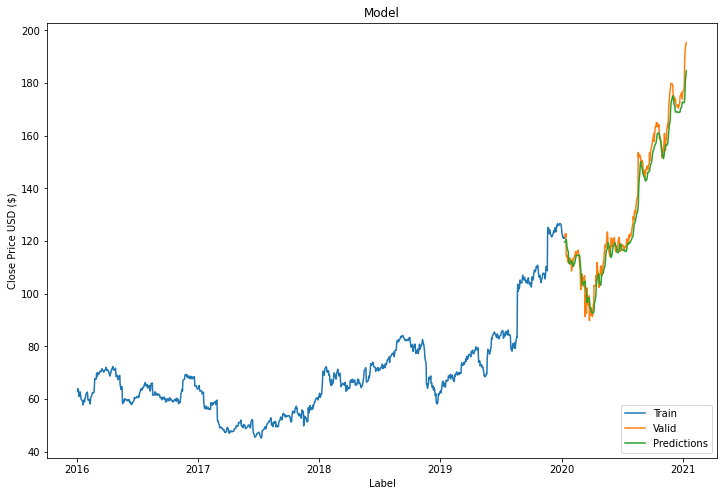

In [27]:
make_prediction(model, X_test,y_test, training_data_len )

In [28]:
#get models predicted price values for X_test dataset
#want predcitions to contain same values as y_test dataset once we inverse_transform
#getting predcitiosn off of X_test
# predictions = model.predict(X_test)
# prediction_unscaled = scaler.inverse_transform(predictions) #unscaling the values

In [29]:
# #predictions_y = model.predict(X_test)
# y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1,1)) #unscaling the values

In [30]:
# #evaluate model w/RMSE
# rmse = np.sqrt(np.mean(predictions-y_test)**2)
# rmse

In [31]:
# #this is in dollars
# rmse_predictions = np.sqrt(np.mean(prediction_unscaled -y_test_unscaled)**2)
# rmse_predictions


In [32]:
from sklearn import metrics

In [33]:
# print(np.sqrt(metrics.mean_squared_error(y_test,predictions)))

In [34]:
#predictions = pd.DataFrame(prediction_unscaled, columns=['Predictions'])

In [35]:
# train = dataset[:training_data_len]
# valid = dataset[training_data_len:] #data from index training_data_len to 

In [36]:
#valid.reset_index(inplace=True)

In [37]:
#valid['Prediction'] = predictions['Predictions']

In [38]:
#valid1 = valid.set_index('Date')

In [39]:
"""
blue-data model was trainined on 
orange-actual closing stock price for rest of days
green-what model predcited values to be

predict closing price fo TGT stock for 2021-1-11  199.10

get the quote
"""
def get_quote(new_df):
    #get last 60days closing values and convert datframe to an array
    last_60_days = new_df[-60:].values #converts to array
    #scale data
    last_60_days_scaled = scaler.transform(last_60_days)
    #create empty list
    x_test = []
    #append last 60 days to x_test
    x_test.append(last_60_days_scaled)
    #conert x_test to a numpy array
    x_test = np.array(x_test)
    # #reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
    #get the predicted scaled price
    pred_price = model.predict(x_test)
    #undo the scaling 
    pred_price = scaler.inverse_transform(pred_price) 
    #what model thinks predicted price will be for 12/18/2019
    #the actual prcie was $69.94
    #DAL: 58.58, 2021-1-11 40.19
    return pred_price                    

In [40]:
get_quote(dataset)

array([[187.65373]], dtype=float32)

## New Model

(1265, 6)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-04,657.719971,627.510010,656.289978,636.989990,9314500,636.989990
2016-01-05,646.909973,627.650024,646.859985,633.789978,5822600,633.789978
2016-01-06,639.789978,620.309998,622.000000,632.650024,5329200,632.650024
2016-01-07,630.000000,605.210022,621.799988,607.940002,7074900,607.940002
2016-01-08,624.140015,606.000000,619.659973,607.049988,5512900,607.049988
...,...,...,...,...,...,...
2021-01-05,3223.379883,3165.060059,3166.010010,3218.510010,2655500,3218.510010
2021-01-06,3197.510010,3131.159912,3146.479980,3138.379883,4394800,3138.379883
2021-01-07,3208.540039,3155.000000,3157.000000,3162.159912,3514500,3162.159912


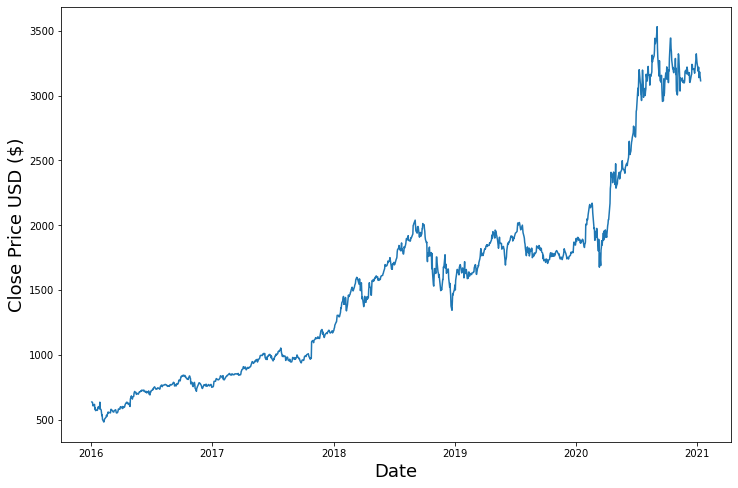

In [41]:
the_data = get_data('AMZN',data_source='yahoo', start='2016-01-01',end='2021-1-11')
the_data

In [42]:
training_data_len, dataset, scaler, scaled_data = preprocessing(the_data['Adj Close'], percentage=.8)

In [43]:
X_train, X_test, y_train, y_test = create_sets(training_data_len)

In [44]:
model_params.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)               

In [45]:
#model.fit(X_train,y_train, epochs=50,batch_size=32,callbacks=[early_stop])  

(64.477925055583,
               Adj Close   Prediction
 Date                                
 2020-01-10  1883.160034  1871.349487
 2020-01-13  1891.300049  1868.400635
 2020-01-14  1869.439941  1864.472656
 2020-01-15  1862.020020  1857.570679
 2020-01-16  1877.939941  1848.689331
 ...                 ...          ...
 2021-01-05  3218.510010  3190.773926
 2021-01-06  3138.379883  3168.763916
 2021-01-07  3162.159912  3135.662354
 2021-01-08  3182.699951  3108.203369
 2021-01-11  3114.209961  3096.518066
 
 [253 rows x 2 columns])

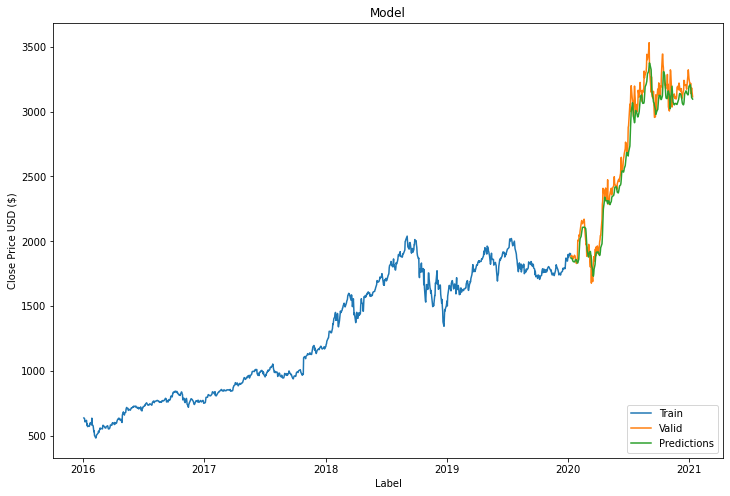

In [46]:
make_prediction(model_params, X_test,y_test, training_data_len )

In [47]:
get_quote(dataset)

array([[3084.3013]], dtype=float32)

In [48]:
# def get_data(symbol, data_source,start,end):
#     df = web.DataReader(symbol,data_source, start, end) 
#     print(df.shape)
    
#     def preprocessing(df,percentage):
#         training_data_len = int(np.round(len(df) * percentage))
#         dataset = pd.DataFrame(df)
#         scaler = MinMaxScaler(feature_range = (0, 1))
#         scaled_data = scaler.fit_transform(dataset)
#         #return training_data_len, dataset, scaler, scaled_data

#         return df, training_data_len, dataset, scaler, scaled_data

#     preprocessing()

In [49]:
# the_data = get_data(symbol='TGT',data_source='yahoo', start='2016-01-01',end='2021-1-11')
# the_data

In [50]:
# def preprocessing(df,percentage):
#     training_data_len = int(np.round(len(df) * percentage))
#     dataset = pd.DataFrame(df)
#     scaler = MinMaxScaler(feature_range = (0, 1))
#     scaled_data = scaler.fit_transform(dataset)
#     return training_data_len, dataset, scaler, scaled_data